In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression 
from itertools import permutations
import statistics

In [3]:
data = pd.read_csv("NYC_Wi-Fi_Hotspot_Locations.csv")
data_census = pd.read_csv("Census_Demographics_at_the_Neighborhood_Tabulation_Area__NTA__level.csv")


In [4]:
# How many unique providers are there?
len(data.Provider.unique())

17

In [5]:
# How many WiFi hotspots are there by the second most common provider in the Bronx?
data[data['Borough Name'] == 'Bronx'].Provider.value_counts()[1]

120

In [6]:
# What fraction of WiFi hotspots are in parks? For simplicity, you can consider a park a place where the name of the location where the WiFi is located contains the word "park".
len(data[data.Location.str.contains('park',case=False)])/len(data)

0.05302802048809883

In [7]:
# What is the probability that a WiFi hotspot is free (without any limitations) given that it's not in a library? For this question, pull the location data based on the "Location_T" field.
non_library_data = data[data.Location_T != 'Library']
free_non_library_data = data[(data.Location_T != 'Library') & (data.Type == 'Free')]
len(free_non_library_data)/len(non_library_data)

0.8122383252818035

In [8]:
# How are WiFi hotspots distributed across neighborhoods? For this question, calculate the number of WiFi hotspots per capita for each Neighborhood Tabulation Area (NTA). Exclude NTAs with less than 30 reported WiFi hotspots. Report the interquartile range of the averages.
# For population data for each NTA, use this dataset; information on the dataset is found here. Use the population data for the column corresponding to 2010.
#data.set_index('Neighborhood Tabulation Area Code (NTACODE)').join(data_census.set_index('Geographic Area - Neighborhood Tabulation Area (NTA)* Code'))
code_counts = data['Neighborhood Tabulation Area Code (NTACODE)'].value_counts()
code_list = code_counts[code_counts.ge(30)] 
tempDF = pd.DataFrame(code_list).join(data_census.set_index('Geographic Area - Neighborhood Tabulation Area (NTA)* Code'))
tempDF['wifi_per_capita'] = tempDF['Neighborhood Tabulation Area Code (NTACODE)']/tempDF['Total Population 2010 Number']
Q1 = tempDF.wifi_per_capita.quantile(.25)
Q3 = tempDF.wifi_per_capita.quantile(.75)
IQR = Q3- Q1
IQR

0.0008508586597922147

In [ ]:
data['day_of_week'] = pd.to_datetime(data.Activated).dt.strftime('%m%y')

In [100]:
# How far must one travel from one hotspot to another? For this question, report the median distance, in feet, of the average distance between each hotspot to the nearest 3 hotspots. For your distance calculation, calculate the distance "as the crow flies". For simplicity, please use the spherical Earth projected to a plane equation for calculating distances. Use the radius of the Earth as 6371 km. Remember, report your answer in feet.
R = 3958.7558657
Latitude_rad = data['Latitude'].apply(math.radians).values
Longitude_rad = data['Longitude'].apply(math.radians).values
Latitude_rad_reg = np.tile(Latitude_rad,(len(Latitude_rad),1))
Latitude_rad_trans = Latitude_rad_reg.T
Longitude_rad_reg = np.tile(Longitude_rad,(len(Longitude_rad),1))
Longitude_rad_trans = Longitude_rad_reg.T
d_phi_sqrd = np.subtract(Latitude_rad_reg, Latitude_rad_trans)**2 
cos_med_phi = np.cos(np.add(Latitude_rad_reg, Latitude_rad_trans)/2)
d_lambda = np.subtract(Longitude_rad_reg, Longitude_rad_trans)
distance = 5280*R*np.sqrt(np.add(d_phi_sqrd,(cos_med_phi * d_lambda)**2))
np.median(np.mean(np.sort(distance,axis=1)[:,1:4],axis=1))



276.34827996962105

In [223]:
#The dataset contains information on the date the hotspot was activated. What fraction of all activations occurred on the day of week that had the most activations? In other words, if Monday had the most activations, what fraction of activations occurred on Monday? Note: there are some dates that don't make sense. Ignore them for the analysis.
filteredData = data[data.Activated != '9/9/9999'].copy()
filteredData['day_of_week'] = pd.to_datetime(filteredData.Activated).dt.strftime('%a')
max(filteredData['day_of_week'].value_counts())/len(filteredData['day_of_week'])

0.24368825466520308

array([[1.52791991]])

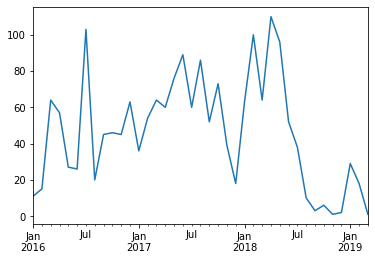

In [269]:
#If you plot the number of hotspot activations for each month, you'll notice a general increase but then a precipitous drop after June 2018. Using a linear estimate for the number of monthly activations, what is rate of increase in monthly activations? Only consider data before July 1, 2018 and set the start date as the earliest date of the data. If you need to, use 30.5 days in a month.
cleanData = data[data.Activated != '9/9/9999'].copy()
cleanData['date'] = pd.to_datetime(cleanData.Activated)
cleanData['date'] .value_counts().sort_index().groupby(pd.Grouper(freq='M')).sum().plot()
filteredData = cleanData[cleanData.date < pd.to_datetime('7/1/2018')]
monthlyData = filteredData['date'] .value_counts().sort_index().groupby(pd.Grouper(freq='M')).sum().reset_index()
#monthlyData
model = LinearRegression()
model.fit(monthlyData.index.values.reshape(-1,1),monthlyData.date.values.reshape(-1,1))
model.coef_



In [61]:
# buildings = range(10)
buildings = [1,1,3,4]

total_sums = []

def calc_distance(bdgs):
    n = len(bdgs)
    tallest = max(bdgs)
    location = bdgs.index(tallest)
    if n == 1:
        return 1
    if location == 0:
        return 1 + calc_distance(bdgs[1:])
    elif location == n-1:
        return location + 1 +  calc_distance(bdgs[:-1])
    else:
        return location + 1 +  calc_distance(bdgs[:location]) + calc_distance(bdgs[location+1:])
    
perms = permutations(buildings)
for perm in perms:
    total_sums.append(calc_distance(perm))

sum_val = statistics.mean(total_sums)
stdev_val = statistics.stdev(total_sums)

decimals = 10
scale = 10**(decimals)
print('mean: ' + str(math.trunc(sum_val*scale)/scale))
print('stdev: ' + str(math.trunc(stdev_val*scale)/scale))


mean: 6.1666666666
stdev: 1.3726099121


In [67]:
buildings = range(20)
n = len(buildings)
# buildings = np.sort(buildings)

temp_dict = {"unique":[0],"cnt":[1]}

value_dict = {1:{"unique":[0],"cnt":[1]},2:{"unique":[0,1],"cnt":[1,1]}}

for i in range(n-2):
    prev_val = i + 2
    next_val = prev_val + 1
    
    unique_dict = np.array(value_dict[prev_val]["unique"])
    count_dict = np.array(value_dict[prev_val]["cnt"])
    
    solution_dict = {"unique":[],"cnt":[]}
        
    for j in range(next_val):
        left_size = j
        right_size = next_val - (j + 1)
        
        if left_size == 0 or right_size == 0:
            max_size = max(left_size,right_size)
            unique_vals = value_dict[max_size]["unique"]
            count_vals = value_dict[max_size]["cnt"] 
        else:
            left_unique = value_dict[left_size]["unique"]
            right_unique = value_dict[right_size]["unique"]
            left_count = value_dict[left_size]["cnt"]
            right_count = value_dict[right_size]["cnt"]        
                
            temp_dict = {}
            for k, left_unique_val in enumerate(left_unique):
                for l, right_unique_val in enumerate(right_unique):
                    unique_val = left_unique_val + right_unique_val
                    count_val = left_count[k] * right_count[l]
 
                    if unique_val in temp_dict:
                        temp_dict[unique_val] += count_val
                    else:
                        temp_dict[unique_val] = count_val
            
            unique_vals = np.array(list(temp_dict.keys()))
            count_vals = np.array(list(temp_dict.values()))

            count_vals = count_vals*math.factorial(next_val-1)/sum(count_vals)                     

        new = np.tile(j,len(unique_vals))
        sum_vals = np.add(new, unique_vals)
        
        solution_dict["unique"].extend(sum_vals)
        solution_dict["cnt"].extend(count_vals)
    
    df = pd.DataFrame(np.array([solution_dict["unique"],solution_dict["cnt"]]).T,columns=["unique","cnt"])    

    df = df.groupby("unique").sum()              
    value_dict[next_val] = {"unique":df.index.values, "cnt":df["cnt"].values}
    

unique_arr = np.add(np.array(value_dict[n]["unique"]),n)
count_arr = np.array(value_dict[n]["cnt"])
total_count = sum(count_arr)
sum_val = sum(np.multiply(unique_arr,count_arr))/total_count
normal_unique = np.add(unique_arr,-sum_val)
stdev_val = math.sqrt(sum(np.multiply(np.multiply(normal_unique,normal_unique),count_arr))/(total_count-1))

decimals = 10
scale = 10**(decimals)
print('mean: ' + str(math.trunc(sum_val*scale)/scale))
print('stdev: ' + str(math.trunc(stdev_val*scale)/scale))
        
    
    

mean: 55.5525328
stdev: 10.0269375501
